In [1]:
!pip install scanpy
!pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
    


import importlib

In [3]:
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est_new.h5ad")


## Correlation scaling

In [51]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen2, R_est2 = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=1, R_est=None, check_pd=False)
data_null_gen2

AnnData object with n_obs × n_vars = 1544 × 5553

In [52]:
sc.pp.calculate_qc_metrics(data_null_gen2)
data_null_gen2.var["var_counts"] = np.asarray(np.var(data_null_gen2.X, axis=0)).squeeze()
data_null_gen2.var["mean_counts"] = np.asarray(np.mean(data_null_gen2.X, axis=0)).squeeze()

In [53]:
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_gen = cd.schaefer_strimmer(data_null_gen2.X, use_corr=True)

large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
frob = np.linalg.norm(cor_orig[large_cor] - cor_gen[large_cor])
print(frob)

/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


326.5647325667426


In [54]:
from scipy.optimize import golden
importlib.reload(cd)

def opt_fun(factor):
    factor_cor = (np.abs(cor_orig) > 0.1)
    cf = factor_cor * factor
    cf[cf == 0] = 1
    np.fill_diagonal(cf, 1)
    
    data_null_gen_new, R_est_new = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=cf, R_est=R_est2, check_pd=False)
    cor_gen = cd.schaefer_strimmer(data_null_gen_new.X, use_corr=True)

    large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
    frob = np.linalg.norm(cor_orig[large_cor] - cor_gen[large_cor])
    if np.isnan(frob):
        frob = np.inf
    print(frob)
    return frob

In [55]:
large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
print(large_cor)
print(np.sum(large_cor))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
7787807


In [56]:
print(5553**2)

30835809


In [57]:
importlib.reload(cd)
xmin, fval, funcalls = golden(opt_fun, brack=(1, 2), full_output=True, maxiter=20)

/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


322.83912336571825


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


343.33467919597143


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")


433.46841851346176


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


322.83912336571825


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")


423.8543398003272


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


323.7966150770042


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


369.92320849952836


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


308.72483641112626


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


312.6065717811235


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


309.1267921070416


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


309.36548938128067


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.83690337226943


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


308.01795058853855


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


308.29693411029376


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.4601068518769


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.92055721541476


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


308.2439004721404


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.9864678761955


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


308.0810866203407


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")


307.51535763173644


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.96088052999323


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


308.38290500580365


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.9190689017395


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")
/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


307.78944201225073


/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")


307.7954416452965


In [58]:
print(xmin)
print(fval)
print(funcalls)

1.1195867981531995
307.4601068518769
25


In [59]:
importlib.reload(cd)

factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)

print(cf[:20, :20])

data_null_gen_opt, R_est_opt = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=cf, R_est=R_est2, check_pd=False)

print(R_est_opt)
data_null_gen_opt

[[1.        1.1195868 1.1195868 1.1195868 1.1195868 1.1195868 1.
  1.1195868 1.1195868 1.        1.1195868 1.1195868 1.1195868 1.
  1.1195868 1.1195868 1.1195868 1.1195868 1.1195868 1.1195868]
 [1.1195868 1.        1.1195868 1.1195868 1.1195868 1.1195868 1.
  1.1195868 1.1195868 1.1195868 1.1195868 1.1195868 1.        1.
  1.1195868 1.1195868 1.1195868 1.1195868 1.1195868 1.1195868]
 [1.1195868 1.1195868 1.        1.1195868 1.1195868 1.1195868 1.
  1.1195868 1.1195868 1.        1.1195868 1.1195868 1.1195868 1.
  1.        1.1195868 1.1195868 1.1195868 1.1195868 1.1195868]
 [1.1195868 1.1195868 1.1195868 1.        1.1195868 1.1195868 1.
  1.1195868 1.1195868 1.1195868 1.1195868 1.1195868 1.        1.
  1.1195868 1.1195868 1.1195868 1.1195868 1.1195868 1.1195868]
 [1.1195868 1.1195868 1.1195868 1.1195868 1.        1.1195868 1.
  1.1195868 1.1195868 1.        1.1195868 1.        1.1195868 1.
  1.        1.1195868 1.1195868 1.1195868 1.1195868 1.       ]
 [1.1195868 1.1195868 1.1195868 1.1

/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_est, size=new_data_shape[0], method="eigh", check_valid="raise")


[[1.         0.26249046 0.31220566 ... 0.24356537 0.36191239 0.2026311 ]
 [0.26249046 1.         0.24536499 ... 0.22913499 0.29338719 0.14184897]
 [0.31220566 0.24536499 1.         ... 0.29169972 0.41104126 0.2477714 ]
 ...
 [0.24356537 0.22913499 0.29169972 ... 1.         0.37530486 0.17804479]
 [0.36191239 0.29338719 0.41104126 ... 0.37530486 1.         0.39588674]
 [0.2026311  0.14184897 0.2477714  ... 0.17804479 0.39588674 1.        ]]


AnnData object with n_obs × n_vars = 1544 × 5553

In [60]:
data_null_gen_opt.var_names = data_gene.var_names
sc.pp.calculate_qc_metrics(data_null_gen_opt)
data_null_gen_opt.var["var_counts"] = np.asarray(np.var(data_null_gen_opt.X, axis=0)).squeeze()
data_null_gen_opt.var["mean_counts"] = np.asarray(np.mean(data_null_gen_opt.X, axis=0)).squeeze()

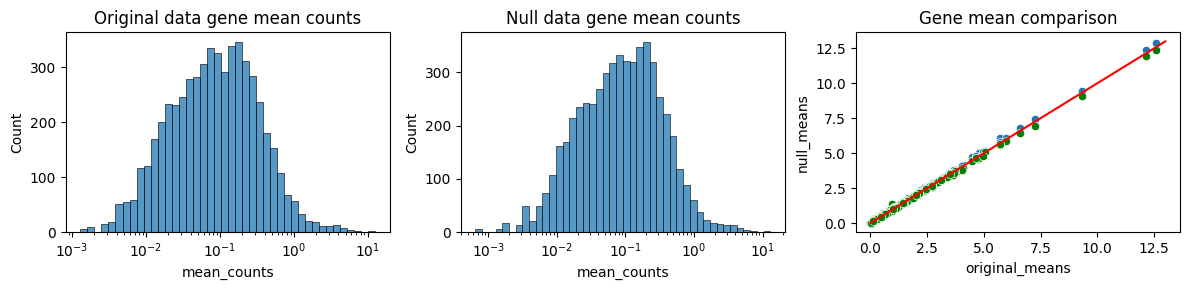

SignificanceResult(statistic=0.9953397641771602, pvalue=0.0)


In [61]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen_opt.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen2.var["mean_counts"]})
mean_df_opt = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen_opt.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2], color="green")
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

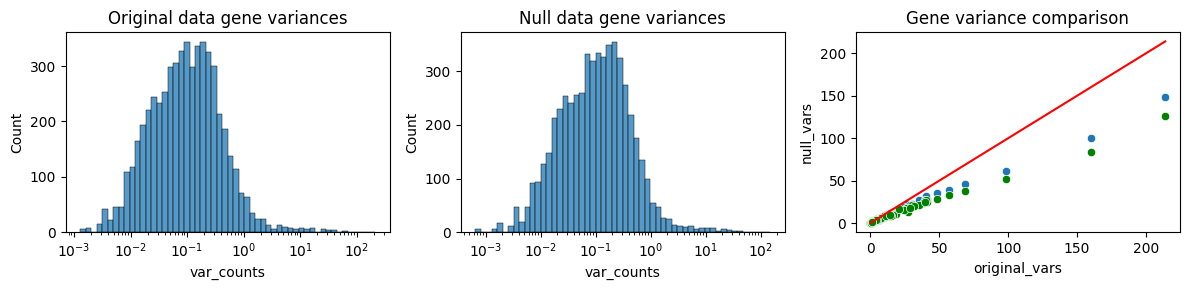

SignificanceResult(statistic=0.9922216061132675, pvalue=0.0)
[[1.         0.99699581]
 [0.99699581 1.        ]]


In [62]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen_opt.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen2.var["var_counts"]})
var_df_opt = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen_opt.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])
g = sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2], color="green")

# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

[None, None]

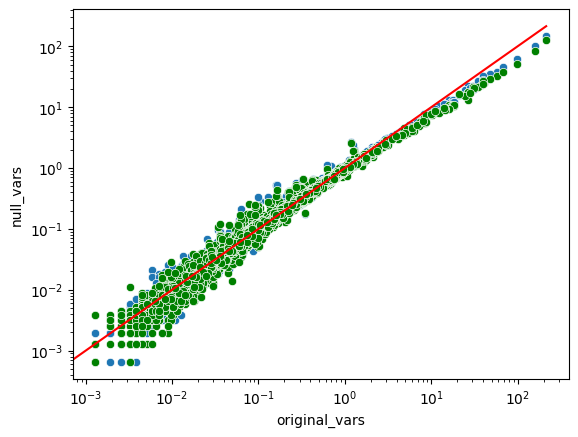

In [63]:
g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars")
g = sns.scatterplot(var_df, y="null_vars", x="original_vars", color="green")
g.plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")

g.set(xscale="log", yscale="log")

/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


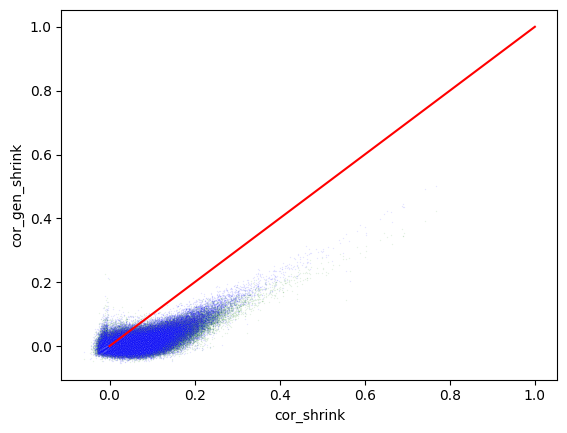

In [64]:
cor_shrink = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen2.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink_opt = cd.schaefer_strimmer(data_null_gen_opt.X, use_corr=True)
cor_gen_shrink_opt = pd.DataFrame(cor_gen_shrink_opt, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten(), "cor_gen_shrink_opt": cor_gen_shrink_opt.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="green", alpha=0.1)
sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink_opt", s=1,
                color="blue", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.show()

In [1]:

cor_shrink_s = spearmanr(data_gene.layers["counts"].toarray())
cor_shrink_s = pd.DataFrame(cor_shrink_s, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink_s = spearmanr(data_null_gen2.X)
cor_gen_shrink_s = pd.DataFrame(cor_gen_shrink_s, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink_opt_s = spearmanr(data_null_gen_opt.X)
cor_gen_shrink_opt_s = pd.DataFrame(cor_gen_shrink_opt_s, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors_s = pd.DataFrame({"cor_shrink": cor_shrink_s.values.flatten(), "cor_gen_shrink": cor_gen_shrink_s.values.flatten(), "cor_gen_shrink_opt": cor_gen_shrink_opt_s.values.flatten()})

ids = rng.choice(len(all_cors_s), 100000, replace=False)
all_cors_subset_s = all_cors_s.loc[ids]

sns.scatterplot(all_cors_subset_s[all_cors_subset_s['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="green", alpha=0.1)
sns.scatterplot(all_cors_subset_s[all_cors_subset_s['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink_opt", s=1,
                color="blue", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset_s['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset_s['cor_shrink']))],
         color="red")
plt.show()

NameError: name 'spearmanr' is not defined

/dss/dsshome1/0A/ra72guj2/BacSC/tools/ClusterDE.py:289: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


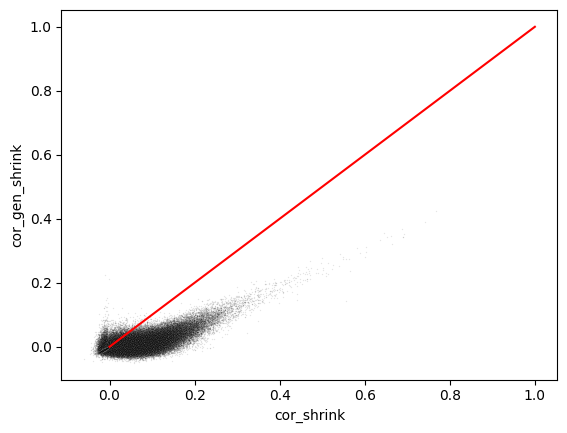

In [65]:
cor_gen_shrink = cd.schaefer_strimmer(data_null_gen2.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.show()

In [66]:
# cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
# cor_gen = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray())
cor_gen = np.corrcoef(data_null_gen_opt.X)
cor_ratio = np.mean(cor_orig)/np.mean(cor_gen)
print(cor_ratio)

1.1387179621429964


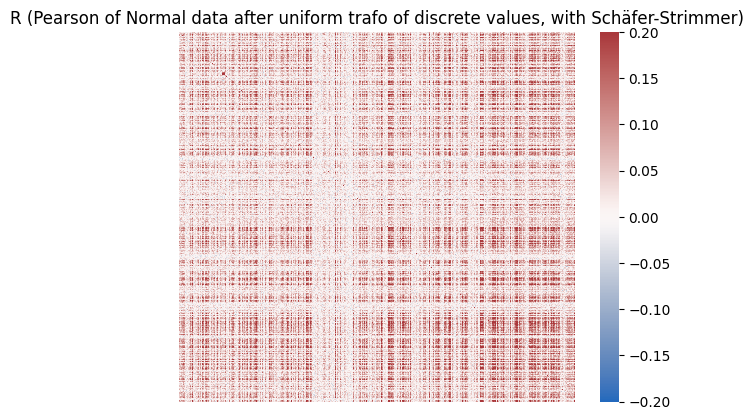

In [67]:
sns.heatmap(R_est_opt,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R (Pearson of Normal data after uniform trafo of discrete values, with Schäfer-Strimmer)")
plt.show()

In [46]:
data_null_gen_opt.obs = pd.DataFrame(index = data_gene.obs.index)
data_null_gen_opt

AnnData object with n_obs × n_vars = 1544 × 5553
    var: 'var_counts', 'mean_counts'

In [68]:
data_null_gen_opt.write_h5ad("../../data/MOBA_scRNAseq/outs_S3/null_data_opt_cor_scale_new.h5ad")

In [ ]:
print(np.max)